In [2]:
# Some initial setup
options(digits = 3)
#install.packages("tidyverse")
library(tidyverse)

theme_set(theme_bw())

#read in data
kcDat <- readRDS('../data/inspections.rds')

## The Problem

We would like to design a risk score for restaurants to determine the allocation of health inspection resources. Currently, all restaurants are required to be visited the same number of times in a year. A health department is considering using data to "target" health inspections: i.e., sending inspectors out based on predicted violations.  The idea is that this could use public resources more efficiently and secure compliance in a better way. 

## The Data

The `kcDat` data frame contains information on restaurant inspections in King County, Washington between 2006 and 2012. The inspection data has been merged with Yelp review information.


 - Variables of interest
      - `score`: score for inspection; higher scores mean there were more violations/penalties
      - `prior_score`: the inspection score for the prior inspection for that establishment
      - `prior_avg_score`: the average of prior score from several years
      - `year`: the year the inspection occurred (resulting in `score`) occurred
      - `asian`: whether the restaurant serves Asian cuisine
      - `yelp_reviews`: the number of reviews for that restaurant written on Yelp
      - `yelp_rating`: the average star rating on Yelp


Let's examine the first few rows of the dataset using the `head` command:

In [3]:
head(kcDat)

score,prior_score,prior_avg_score,year,asian,yelp_reviews,yelp_rating
0,35,22.4,2012,1,1,5.00
0,40,23.3,2012,1,3,4.00
40,10,21.6,2011,1,7,4.43
10,25,22.9,2011,1,3,3.33
25,0,22.6,2010,1,4,3.25
0,25,25.9,2010,1,1,2.00


Let's posit that receiving an inspection score of 10 or more points counts as a serious violation. The health department is interested in targeting these establishments with more frequent inspections.  Please calculate a `serious_viol` indicator below and add it to the `kcDat` data frame. 

In [4]:
# WRITE CODE HERE
# START solution
kcDat <- kcDat %>% 
    mutate(serious_viol = score >= 10)
# END solution

## Test / Train Split 
As is conventional in machine learning, let's split the data into training and test sets. We will use the training dataset to develop the model and the test set to evaluate results. We'll set a random seed (to enable replicability) and use 70% of the data for training a model and 30% of the data for testing the model. 

In [5]:
#get a random subset of data to fit naive model
set.seed(1231)

#take 70% of data to train - leave 30% to evaluate accuracy
train <- sample(1:nrow(kcDat), floor(nrow(kcDat)*.7), replace=FALSE)

train_sub <- kcDat[train,]
test_sub <- kcDat[-train,]

## Baseline Accuracy
Let's set up a baseline of predictive performance.  The baseline is really simple: we will predict the modal value of `serious_viol` in the training sample. Calculate the mean and mode  in the training data.  The calculate the accuracy in the test data, where accuracy is the percentage correctly predicted.  This is our baseline accuracy. 

In [6]:
# Helper function to calculate mode in vector v
get_mode <- function(v) {
    uniqv <- unique(v)
    my_mode <- uniqv[which.max(tabulate(match(v, uniqv)))]
    as.numeric(my_mode)
}

# WRITE CODE HERE
# START solution
train_mode <- train_sub %>% 
        summarize(serious_viol_rate = mean(serious_viol),
                  serious_viol_mode = get_mode(serious_viol))
train_mode

test_sub %>% 
    summarize(accuracy = mean(train_mode$serious_viol_mode == serious_viol))

# END solution

serious_viol_rate,serious_viol_mode
0.473,0


accuracy
0.516


## Model 1: Logistic Regression

Let's now fit a logistic regression to predict whether an establishment is likely to fail its inspection.  Let's use all variables above, except for the Asian cuisine indicator. 

Interpret the coefficients. Note that the intercept will represent the baseline year of 2006 (the omitted year). 

In [7]:
## Recall the syntax for logistic regression:
##
## glm_inspect <- glm(serious_viol ~ var1 + var2, data = train_sub, family = binomial)
##
## And that exponentiating the coeficients provides you with odds ratios
##
## exp(coef(glm_inspect))
##

# WRITE CODE HERE
# START solution
glm_inspect <- glm(serious_viol ~ prior_score + prior_avg_score + year + yelp_reviews + yelp_rating,
                   data = train_sub, 
                   family = binomial)

exp(coef(glm_inspect))
# END solution

(Intercept)     prior_score prior_avg_score        year2007        year2008 
          0.827           1.005           1.043           0.840           0.752 
       year2009        year2010        year2011        year2012        year2013 
          0.645           0.690           0.652           0.679           0.587 
   yelp_reviews     yelp_rating 
          1.001           0.955

### Assess prediction ability

Now that we've fit a model, let's assess the accuracy of the predictions. 

Recall that you can predict new values from your model using the `predict()` function, which takes `newdata = test_sub` as an input to predict values on the test data, as well as `type = "response"` to predict values on a probability scale. 

For simplicity, let's use a threshold of 0.5 to predict when a restaurant will have a serious violation in the test set.  How often does this prediction equal the observed `serious_viol` in the test set, which is one measure of accuracy? 

In [8]:
## Predicting serious violations on the test set 
score_pred_inspect <- predict(glm_inspect, newdata=test_sub, type="response")

## Accuracy
mean((score_pred_inspect >= 0.5) == test_sub$serious_viol)

[1] 0.609

## Model 2: Cuisine Category

Now let's try adding the indicator for Asian cuisine to examine whether this will improve accuracy. 

Go through the same steps as before: (1) Fit the model and examine the odds ratio with Asian.  (2) Create a `score_pred` vector that stores all of the predictions in `test_sub`.  (3) Calculate the accuracy of these predictions. 

In [9]:
# WRITE CODE HERE
# START solution
glm_asian <- glm(serious_viol ~ prior_score + prior_avg_score + year + asian, data=train_sub, 
                 family = binomial)

exp(coef(glm_asian))
              
score_pred <- predict(glm_asian, newdata = test_sub, type = "response")

mean((score_pred >= 0.5) == test_sub$serious_viol)
# END solution

(Intercept)     prior_score prior_avg_score        year2007        year2008 
          0.655           1.005           1.037           0.872           0.783 
       year2009        year2010        year2011        year2012        year2013 
          0.671           0.712           0.674           0.696           0.613 
          asian 
          1.435

[1] 0.61

## Comparing False Positive Rates

Let's examine the rate at which restaurants are predicted to have serious violations by cuisine.  

In [10]:
## Let's add a variable to indicate whether the prediction is above the cutpoint
test_sub <- test_sub %>% 
    mutate(pred_above_cut = score_pred >= 0.5)

## Now calculate what the positive rate is by Asian vs. non-Asian establishment

## Then do the same by whether the establishment actually had a serious violation.  

# WRITE CODE HERE
# START solution
test_sub %>% 
    group_by(asian) %>%
    summarize(positive_rate = mean(pred_above_cut))

test_sub %>% 
    group_by(asian, serious_viol) %>%
    summarize(positive_rate = mean(pred_above_cut))
# END solution

asian,positive_rate
0,0.195
1,0.744


asian,serious_viol,positive_rate
0,FALSE,0.132
0,TRUE,0.276
1,FALSE,0.671
1,TRUE,0.794


To understand what is driving this disparity, we can plot the densities of inspection scores grouped by cuisine. 

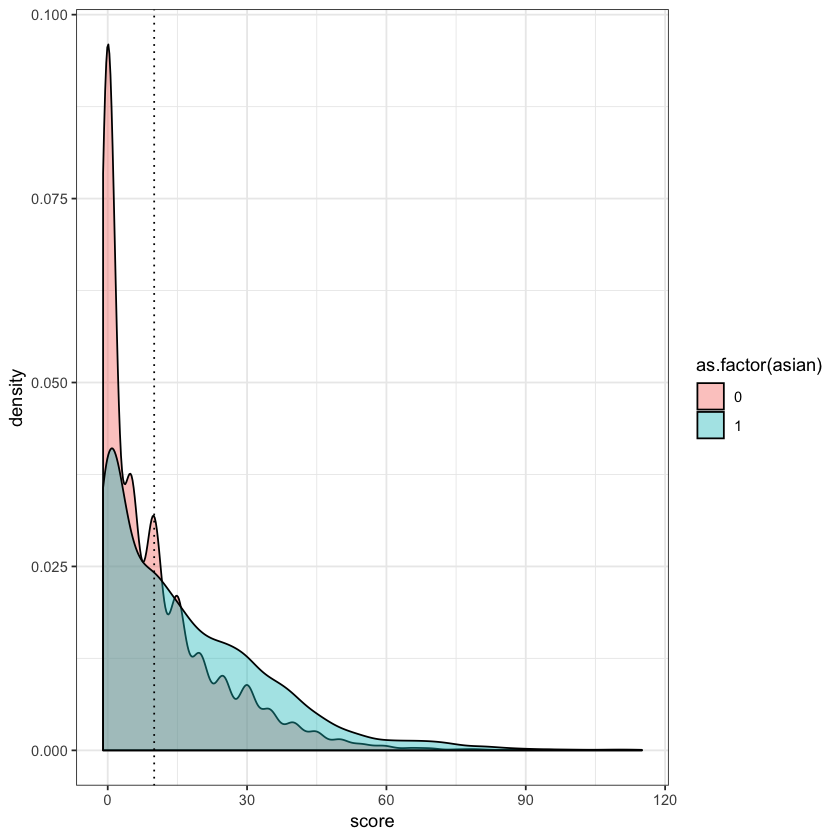

In [11]:
#run this cell to plot the densities
ggplot(kcDat, aes(x=score, fill=as.factor(asian))) +
  geom_density(alpha=0.4) + geom_vline(xintercept = 10, linetype="dotted")

We can see from the distributions that no matter where the cutoff is set, more Asian restaurants will likely be predicted as high risk than non-Asian restaurants.

Discussion Questions: 

   - Which model would you pick? Why?
   - How would you think about the fairness of this algorithmic targeting? 
   - Does the use of Yelp data worry you? 
   - What other data might you be interested in adding to your model? Are there any potential biases or drawbacks to adding the data?
   - Consider the fact that some inspectors are more harsh than others when grading (see https://www.thestranger.com/seattle/mr-clean/Content?oid=568012). What will this mean for the allocation of inspection resources? 

References

   - Kristen M. Altenburger and Daniel E. Ho, [Is Yelp Actually Cleaning Up the Restaurant Industry? A Re-Analysis on the Relative Usefulness of Consumer Reviews](https://dho.stanford.edu/wp-content/uploads/YelpReplicate_FinalWWW2019_neutral.pdf) WWW Proceedings (2019).
   - Kristen M. Altenburger and Daniel E. Ho, [When Algorithms Import Private bias into Public Enforcement: The Promise and Limitations of Statistical Debiasing Solutions](https://dho.stanford.edu/wp-content/uploads/JITE-FinalVersion.pdf) 175 Journal of Institutional and Theoretical Economics 98-122 (2019).